In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torchvision

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'expandable_segments:True'
torch.cuda.empty_cache()

In [ ]:
covid_directory = f'/content/gdrive/MyDrive/New Images for Classification/COVID-19'
normal_directory = f'/content/gdrive/MyDrive/New Images for Classification/Normal'
pneumonia_directory = f'/content/gdrive/MyDrive/New Images for Classification/Pneumonia'

image_size = (299, 299)

def load_images(directory):
    class_images = []
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image, image_size)
        resized_image = resized_image.astype(np.float16)
        normalized_image = resized_image / 255.0
        class_images.append(normalized_image)

    return np.array(class_images)

covid_images = load_images(covid_directory)
normal_images = load_images(normal_directory)
pneumonia_images = load_images(pneumonia_directory)

print(covid_images.shape)
print(normal_images.shape)
print(pneumonia_images.shape)

(522, 299, 299, 3)
(1017, 299, 299, 3)
(1197, 299, 299, 3)


In [ ]:
torch.cuda.empty_cache()

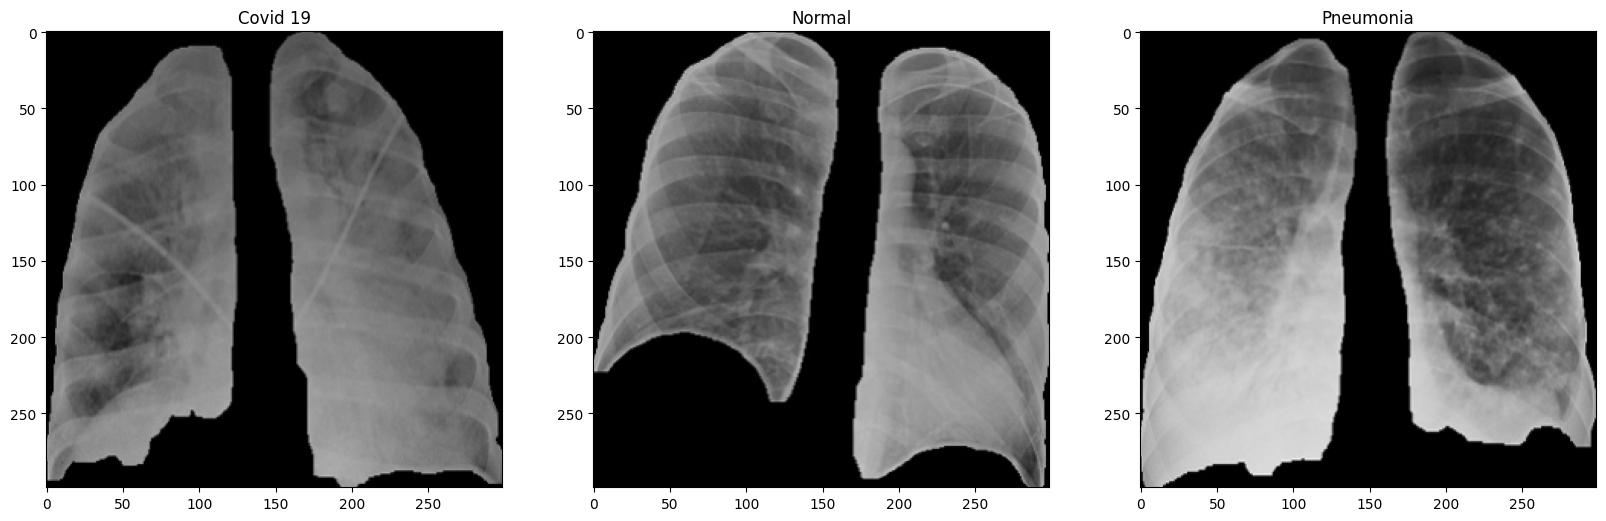

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize = (20,20))
ax[0].imshow(covid_images[0])
ax[0].title.set_text("Covid 19")
ax[1].imshow(normal_images[0])
ax[1].title.set_text("Normal")
ax[2].imshow(pneumonia_images[0])
ax[2].title.set_text("Pneumonia")

In [ ]:
all_images = np.concatenate((covid_images, normal_images, pneumonia_images), axis=0)
print(all_images.shape)
covid_labels = np.zeros(len(covid_images), dtype=np.int16)
pneumonia_labels = np.ones(len(pneumonia_images), dtype=np.int16)
normal_labels = np.full(len(normal_images), 2, dtype=np.int16)

all_labels = np.concatenate((covid_labels, normal_labels, pneumonia_labels), axis=0)
print(all_labels.shape)

(2736, 299, 299, 3)
(2736,)


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

class_counts = Counter(all_labels)
minority_class = min(class_counts, key=class_counts.get)
desired_ratio = dict(Counter(class_counts))
desired_ratio[minority_class] = len(all_images) // len(class_counts)
sm = SMOTE(sampling_strategy = desired_ratio, random_state=42)
flattened_images = all_images.reshape(all_images.shape[0], -1)
resampled_images, resampled_labels = sm.fit_resample(flattened_images, all_labels)

In [ ]:
print(resampled_images.shape)

(3126, 268203)


In [ ]:
original_shape = all_images.shape[1:]
new_images_res = resampled_images.reshape(-1, *original_shape)
print(new_images_res.shape)

(3126, 299, 299, 3)


In [ ]:
train_val_split, test_split = 0.8, 0.2
X_train_val, X_test, y_train_val, y_test = train_test_split(new_images_res, resampled_labels, train_size = train_val_split, test_size = test_split, random_state=42, stratify=resampled_labels)
train_split, val_split = 0.9, 0.1
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=train_split, test_size=val_split, random_state=42, stratify=y_train_val)

import torch
from torch import nn
from torchvision import models

def create_model():
    model = models.inception_v3(weights='DEFAULT')
    for parameter in model.parameters():
        parameter.requires_grad = True

    input_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(input_features, 3),
        nn.Softmax(dim=1)
    )

    return model

model = create_model()







In [ ]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

num_epochs = 6
batch_size= 16


X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_val = torch.tensor(X_val)
y_val = torch.tensor(y_val)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy


train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
validation_dataset = torch.utils.data.TensorDataset(X_val, y_val)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


train_acc_list = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)
        images = images.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        labels = labels.long()
        images = images.type(torch.FloatTensor).to(device)
        outputs = model(images)
        num_classes = 3
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes)
        proper_labels = torch.argmax(one_hot_labels, dim=1)
        logits = outputs.logits
        outputs = torch.as_tensor(logits)
        loss = criterion(outputs, proper_labels)
        loss.backward()
        optimizer.step()


        total_loss += loss.item()


        accuracy = calculate_accuracy(outputs, proper_labels)
        total_accuracy += accuracy

        if (i + 1) % 10 == 0 or i + 1 == len(train_data_loader):
            avg_loss = total_loss / (i + 1)
            avg_accuracy = total_accuracy / (i + 1)


            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_data_loader)}], "
                  f"Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")


    avg_epoch_loss = total_loss / len(train_data_loader)
    avg_epoch_accuracy = (100 * total_accuracy) / len(train_data_loader)
    train_acc_list.append(avg_epoch_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}, "
          f"Average Accuracy: {avg_epoch_accuracy:.4f}")

print("Training complete")




Epoch [1/6], Step [10/141], Loss: 1.0598, Accuracy: 0.5062
Epoch [1/6], Step [20/141], Loss: 1.0000, Accuracy: 0.6062
Epoch [1/6], Step [30/141], Loss: 0.9662, Accuracy: 0.6333
Epoch [1/6], Step [40/141], Loss: 0.9260, Accuracy: 0.6625
Epoch [1/6], Step [50/141], Loss: 0.8995, Accuracy: 0.6763
Epoch [1/6], Step [60/141], Loss: 0.8838, Accuracy: 0.6875
Epoch [1/6], Step [70/141], Loss: 0.8657, Accuracy: 0.7071
Epoch [1/6], Step [80/141], Loss: 0.8522, Accuracy: 0.7164
Epoch [1/6], Step [90/141], Loss: 0.8438, Accuracy: 0.7208
Epoch [1/6], Step [100/141], Loss: 0.8367, Accuracy: 0.7275
Epoch [1/6], Step [110/141], Loss: 0.8317, Accuracy: 0.7312
Epoch [1/6], Step [120/141], Loss: 0.8274, Accuracy: 0.7349
Epoch [1/6], Step [130/141], Loss: 0.8210, Accuracy: 0.7404
Epoch [1/6], Step [140/141], Loss: 0.8153, Accuracy: 0.7460
Epoch [1/6], Step [141/141], Loss: 0.8141, Accuracy: 0.7471
Epoch [1/6], Average Loss: 0.8141, Average Accuracy: 74.7074
Epoch [2/6], Step [10/141], Loss: 0.7216, Accura

In [ ]:
val_accuracy_list = []
model.eval()
with torch.no_grad():
  val_loss = 0.0
  val_correct = 0
  total_samples = 0
  for epoch in range(0, num_epochs):
    for i, (images, labels) in enumerate(validation_data_loader):
      images.to(device)
      labels.to(device)
      images = images.permute(0,3,1,2)
      labels = labels.long()
      images = images.type(torch.FloatTensor).to(device)
      outputs = model(images)
      val_loss += criterion(outputs, labels).item() * images.size(0)
      _, predicted = torch.max(outputs.data, 1)
      val_correct += (predicted == labels).sum().item()
      total_samples += labels.shape[0]

    val_accuracy = 100.0 * val_correct / total_samples
    avg_loss = val_loss / total_samples
    val_accuracy_list.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1/6], Validation Loss: 0.6703, Validation Accuracy: 88.00%
Epoch [2/6], Validation Loss: 0.6703, Validation Accuracy: 88.00%
Epoch [3/6], Validation Loss: 0.6703, Validation Accuracy: 88.00%
Epoch [4/6], Validation Loss: 0.6703, Validation Accuracy: 88.00%
Epoch [5/6], Validation Loss: 0.6703, Validation Accuracy: 88.00%
Epoch [6/6], Validation Loss: 0.6703, Validation Accuracy: 88.00%


[74.70744680851064, 83.51063829787235, 87.33156028368795, 89.13120567375887, 90.97517730496453, 93.26241134751773]
[88.0, 88.0, 88.0, 88.0, 88.0, 88.0]


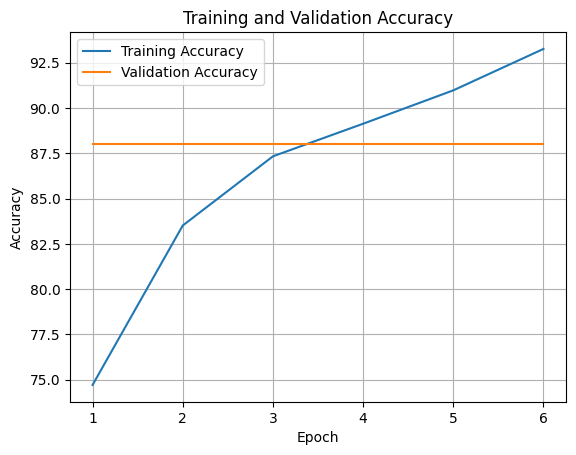

In [ ]:
print(train_acc_list)
print(val_accuracy_list)
plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_list) + 1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)
X_test = X_test.to(device)
y_test = y_test.to(device)

test_data_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

model.eval()
with torch.no_grad():
  test_loss = 0.0
  test_correct = 0
  total_samples = 0
  predicted_labels = []
  true_labels = []
  for i, (images, labels) in enumerate(test_data_loader):
    images = images.permute(0,3,1,2)
    labels = labels.long()
    images = images.type(torch.FloatTensor).to(device)
    outputs = model(images)
    test_loss += criterion(outputs, labels).item() * images.size(0)
    _, predicted = torch.max(outputs.data, 1)
    test_correct += (predicted == labels).sum().item()
    total_samples += labels.shape[0]

    predicted_labels.extend(predicted.cpu().tolist())
    true_labels.extend(labels.cpu().tolist())

  test_accuracy = 100.0 * test_correct / total_samples
  test_loss = test_loss / total_samples

  from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

  accuracy = accuracy_score(true_labels, predicted_labels)
  precision = precision_score(true_labels, predicted_labels, average='macro')
  recall = recall_score(true_labels, predicted_labels, average='macro')
  f1 = f1_score(true_labels, predicted_labels, average='macro')

  print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.2f}%")
  print(f"Accuracy Score: {accuracy:.4f}")
  print(f"Macro Precision: {precision:.4f}")
  print(f"Macro Recall: {recall:.4f}")
  print(f"Macro F1-Score: {f1:.4f}")

<ipython-input-25-54e4aa76e504>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)
<ipython-input-25-54e4aa76e504>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test)


Testing Loss: 0.6907, Testing Accuracy: 85.94%
Accuracy Score: 0.8594
Macro Precision: 0.8663
Macro Recall: 0.8558
Macro F1-Score: 0.8593


Micro Precision: 0.8594
Micro Recall: 0.8594
Micro F1-Score: 0.8594


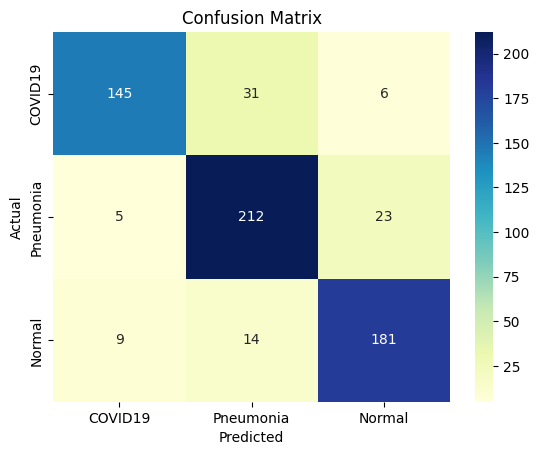

In [ ]:
import seaborn as sns

micro_precision = precision_score(true_labels, predicted_labels, average='micro')
micro_recall = recall_score(true_labels, predicted_labels, average='micro')
micro_f1 = f1_score(true_labels, predicted_labels, average='micro')

print(f"Micro Precision: {micro_precision:.4f}")
print(f"Micro Recall: {micro_recall:.4f}")
print(f"Micro F1-Score: {micro_f1:.4f}")

from sklearn.metrics import confusion_matrix
class_labels = ['COVID19', 'Pneumonia', 'Normal']

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, cbar=True, fmt='d', cmap='YlGnBu', xticklabels = class_labels, yticklabels= class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/Model Checkpoints and metrics for Dataset #2 (New)/InceptionV3_complete_saved.pt')
test_metrics = {
  "accuracy": accuracy,
  "Macro precision": precision,
  "Macro recall": recall,
  "Macro f1_score": f1,
  "Micro Precision": micro_precision,
  "Micro Recall": micro_recall,
  "Micro f1_score": micro_f1,
  "confusion_matrix": cm.tolist(),
}

import pickle
with open("/content/gdrive/MyDrive/Model Checkpoints and metrics for Dataset #2 (New)/InceptionV3_complete_test_metrics.pkl", "wb") as f:
  pickle.dump(test_metrics, f)
print("Done!")


Done!
